In [150]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
tfds.disable_progress_bar()
import collections
import pathlib
import re
import string
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import matplotlib.pyplot as plt
import tensorflow_text as tf_text
from tensorflow import keras

In [151]:
tfds.disable_progress_bar()


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [152]:
#batch_size = 32
seed = 42

train_dataset = preprocessing.text_dataset_from_directory(
    'bbc',
#    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)


Found 2225 files belonging to 5 classes.
Using 1780 files for training.


In [153]:
train_dataset

<BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int32)>

In [154]:
test_dataset = preprocessing.text_dataset_from_directory(
    data_dir,
#    batch_size=batch_size,
    validation_split=.2,
    subset='validation',
    seed=seed)

Found 2225 files belonging to 5 classes.
Using 445 files for validation.


In [155]:
test_dataset

<BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int32)>

In [156]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [157]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'to', 'of', 'and', 'a', 'in', 'for', 'is',
       'that', 'on', 'said', 'it', 'was', 'he', 'be', 'with', 'as', 'has'],
      dtype='<U13')

In [158]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[981,  53,   4, ...,   0,   0,   0],
       [  1, 763,   1, ...,   0,   0,   0],
       [571, 255, 833, ...,   0,   0,   0]])

In [159]:
# for n in range(3):
#   print("Original: ", example[n].numpy())
#   print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
#   print()

In [185]:
model = tf.keras.Sequential([
    encoder,  
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='relu')
])

In [186]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [187]:
# # predict on a sample text without padding.

# sample_text = ('The movie was cool. The animation and the graphics '
#                'were out of this world. I would recommend this movie.')
# predictions = model.predict(np.array([sample_text]))
# print(predictions[0])

In [188]:
# # predict on a sample text with padding

# padding = "the " * 2000
# predictions = model.predict(np.array([sample_text, padding]))
# print(predictions[0])

In [189]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [190]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
56/56 [==============================] - 43s 761ms/step - loss: 1.6033 - accuracy: 0.2730 - val_loss: 1.6031 - val_accuracy: 0.2449
Epoch 2/10
56/56 [==============================] - 37s 655ms/step - loss: 1.5939 - accuracy: 0.2534
Epoch 3/10
56/56 [==============================] - 37s 653ms/step - loss: 1.5812 - accuracy: 0.2539
Epoch 4/10
56/56 [==============================] - 33s 591ms/step - loss: 1.5514 - accuracy: 0.2612
Epoch 5/10
56/56 [==============================] - 34s 606ms/step - loss: 1.4804 - accuracy: 0.3298
Epoch 6/10
56/56 [==============================] - 34s 608ms/step - loss: 1.3820 - accuracy: 0.3921
Epoch 7/10
56/56 [==============================] - 33s 591ms/step - loss: 1.2647 - accuracy: 0.4978
Epoch 8/10
56/56 [==============================] - 33s 590ms/step - loss: 1.1391 - accuracy: 0.5191
Epoch 9/10
56/56 [==============================] - 33s 593ms/step - loss: 1.0623 - accuracy: 0.5612
Epoch 10/10
56/56 [==============================

In [191]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

14/14 [==============================] - 1s 85ms/step - loss: 0.9356 - accuracy: 0.6562
Test Loss: 0.9355734586715698
Test Accuracy: 0.6561797857284546


(0.0, 4.410792803764343)

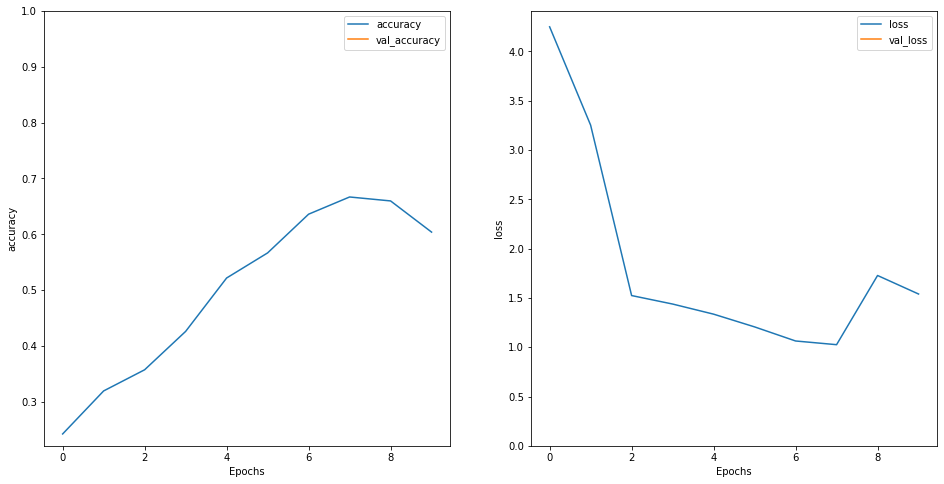

In [126]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

In [84]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

In [85]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [89]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [90]:
history = model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5
63/63 [==============================] - 85s 1s/step - loss: 0.4340 - accuracy: 0.2307 - val_loss: -0.3352 - val_accuracy: 0.1854
Epoch 2/5
22/63 [=========>....................] - ETA: 50s - loss: -1.5678 - accuracy: 0.1690

KeyboardInterrupt: 

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')